In [44]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial

In [28]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

Problemi da affrontare per il training di un DNN - Deep Neural Network:

- **vanishing** o **exploding gradient**. Il gradiente diminuisce o diventa sempre più grande man mano scendo verso i livelli più vicini all'input --> i livelli più vicini all'inout sono più difficili da addestrare
- Non abbastanza dati per il training oppure troppo costoso etichettare i sample
- Training molto lento
- Rischio overfitting 

## Vanishing/exploding gradient

Esiste il rischio che il gradiente diventi sempre più piccolo man mano il gradient descent si avvicina ai livelli più vicini all'input. In questi casi i pesi rimangono inalterati e non osservo alcun apprendimento = **vanishing gradient**. In altri casi il gradiente continua a crescere e l'algoritmo diverge = **exploding gradient**. In generale si osserva un problema di instabilità del gradiente che ha reso queste reti poco utilizzate  fino ai primi anni del 2000. 

Nel 2010, Glorot e Bengio mostrano che la funzione di attivazione sigmoide e il metodo di inizializzazione dei pesi determinano una crescita della varianza dopo ogni livello hidden, determinando una saturazione della funzione di attivazione nei livelli vicini all'output. Ciò è amplificato dalla funzione sigmoide che satura quando i valori di input crescono e per questi valori la derivata è prossima allo 0 => nel backpropagation viene diffuso un valore di gradiente già prossimo allo zero che a sua volta deve essere diviso tra i vari pesi. E' difficile che i livelli vicini ad input vengano aggiornati.

![](dnn_1.png)

### Weight Inizialization
Glorot e Bengio osservano che per evitare i precedenti fenomeni la varianza dell'output di un layer deve essere simile alla varianza degli input dello stesso layer; lo stesso dicasi per il gradiente. Dal momento che il numero di input = **fan-in** e il numero di unità di output = **fan-out** sono generalmente diversi le due condizioni sono difficilmente verificabili contemporaneamente. Un compromesso è dato da **Xavier** o **Gorot inizialization**:

![](dnn_2.png)

Se si rimpiazza $fan_{avg}$ con $fan_{in}$, si ottiene la **LeCun inizialization**. Mediante la Glorot inizialization si rende il training più veloce + promosso il successo delle DNN.

Nella seguente tabella vengono riassunte le inizializzazioni per diversi tipi di funzioni di attivazione:

![](dnn_3.png)

In Keras, l'inizializzazione di default è Glorot con distro uniforme, tuttavia mediante il parametro **kernel_initializer** è possibile modificare il metodo di inizializzazione.

### Activation functions
Il precedente paper ha evidenziato che anche la forma della funzione di attivazione influenza l'instabilità del gradiente. Anche se la sigmoide è utilizzata nei neuroni biologici, ReLU e funzioni affini si comportano meglio nelle DNN. 
La ReLU, tuttavia, determina il problema del **dying ReLUs**: molti neuroni della rete emettono 0 in output, poichè i pesi in ingresso sono negativi e la somma pesata è minore di 0. Per risolvere il problema si utilizza la funzione di attivazione **LeakyReLU**:
$$LReLU_{\alpha}(z) = max(\alpha z, z)$$
dove solitamente $\alpha=0.01$

![](dnn_4.png)

In un articolo del 2015 sono state comparate diverse versioni di ReLU, e LReLU è risultata sempre migliore della ReLU.

In Keras per utilizzare LReLU si crea un **LeakyReLU** layer e lo si aggiunge dopo il layer a cui si vuole applicare la funzione di attivazione.

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Nello stesso anno è stata proposta anche **ELU - exponential linear unit** che migliora le varie varianti della ReLU.

![](dnn_5.png)

- $\alpha$ permette di settare a quale valore negativo la funzione deve tendere con valori negativi molto grandi.
- a un gradiente diverso da 0 per valori negativi
- se $\alpha=1$ la derivata non ha salti
- computazionalmente è più costosa della ReLU, ma con un convergence rate più veloce. Utile nel training, più lenta nella predizione.

Nel 2017 è stata introdotta **Scaled ELU - SELU** che auto-normalizza la rete se tutti gli hidden layer utilizzano SELU e sono densi. Per auto-normalizzazione si intende che la media e la standard deviation dell'output di ogni livello sono 0 e 1 rispettivamente.  Alcune condizioni devono essere verificate:
- input feature devono essere standardizzate
- LeCun inizializer per ogni hidden layer
- architettura sequenziale => no RNN o skip connections in CNN o Wide and Deep.

Per utilizzare SELU basta definire il parametro **activation** nella definizione del layer **Dense** relativo.

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 11ms/step - loss: 1.0076 - accuracy: 0.6162 - val_loss: 0.8929 - val_accuracy: 0.6836
Epoch 2/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6358 - accuracy: 0.7773 - val_loss: 0.5437 - val_accuracy: 0.8146
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5336 - accuracy: 0.8146 - val_loss: 0.5033 - val_accuracy: 0.8214
Epoch 4/5
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4889 - accuracy: 0.8297 - val_loss: 0.4757 - val_accuracy: 0.8342
Epoch 5/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4487 - accuracy: 0.8438 - val_loss: 0.4298 - val_accuracy: 0.8504


### Batch Normalization
Per ridurre il problema del vanishing/exploding gradient, si può utilizzare la tecnica di **Batch Normalization** che consiste nel porre un'operazione prima o dopo la funzione di attivazione di ogni livello in modo da normalizzare l'input e in seguito applicare un rescaling e uno shifting. I parametri delle ultime due operazioni vengono appresi. 

![](dnn_6.png)

Per normalizzare l'input, si utilizza il mini-batch corrente per stimare la media e la standard deviation. $\mathbf{\gamma}$ e $\mathbf{\beta}$ vengono appressi e influenzano lo scaling e lo shifting delle istanze/sample del mini-batch. Non variano al variare del mini-batch. Ogni mini-batch non ha una coppia specifica di parametri.

Per la predizione di nuove istanze non possiamo calcolare la media e la standard deviation. In pratica le due grandezze vengono calcolate utilizzando un aggiornamento online  durante il training. Keras utilizza questo metodo. In sostanza oltre ai parametri di scaling e shifting vengono stimate anche la media e la deviazione standard.

BN ha milgiorato le performance in molti task e con diverse architetture, riducendo il fenomeno del vanishing gradient a tal punto da permettere l'uso di sigmoidi e tanh come funzioni di attivazione.  Inoltre, gli autori di BN hanno potuto utilizzare learning rate più grandi velocizzando il processo di training. Infine BN può agire anche da regularization.

Tuttavia BN aggiunge complessita' al modello e rende la predizine piu' lenta a causa delle computazioni extra, anche se e' possibile inglobare i fattori di scala e shifting direttamenta nella matrice dei pesi e nel vettore dei bias.

In Keras si deve solo aggiungere il layer **Batch Normalization** prima o dopo ogni funzione di attivazione di un hidden layer.

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [50]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_144 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_145 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_146 (Dense)            (None, 10)              

Ogni layer BN aggiunge quattro parametri (784*4 nel primo livello).

In [8]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Ma $\mathbf{\mu}$ e $\mathbf{\sigma}$ non sono addestrabili.

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8581 - accuracy: 0.7180 - val_loss: 0.5714 - val_accuracy: 0.8096
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5753 - accuracy: 0.8020 - val_loss: 0.4908 - val_accuracy: 0.8350
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5130 - accuracy: 0.8223 - val_loss: 0.4509 - val_accuracy: 0.8446
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4803 - accuracy: 0.8310 - val_loss: 0.4283 - val_accuracy: 0.8516
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4549 - accuracy: 0.8406 - val_loss: 0.4095 - val_accuracy: 0.8598
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4366 - accuracy: 0.8452 - val_loss: 0.3998 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4235 - accuracy: 0.8509 - val_loss: 0.3889 - val_accuracy:

Gli autori di BN suggeriscono di inserire BN prima delle funzioni di attivazione, tuttavia il posizionamento e' dipendente dal task. Per aggiungere il layer BN prima della funzione di attivazione, si deve rimuovere la funzione di attivazione del livello denso e aggiungerla come ulteriore layer in seguito.

Inoltre visto che viene introdotto un parametro di shifting/offset, e' possibile omettere il bias mediante il parametro **use_bias**:

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

Nel layer BN posso specificare il parametro **momentum** che agisce sulla stima della media e della standard deviation. Il metodo di aggiiornamento della media mobile diventa:
$$\mathbf{\mu} \leftarrow \mathbf{\mu} * momentum + \mathbf{v} * (1-momentum)$$

Un secondo parametro e' su quale dimensione calcolare la media e la standard deviation. E' specificabile mediante il parametro **axis**.

BN e' molto utilizzato tanto da essere omesso nei diagrammi di rappresentazione delle DNN.

### Gradient Clipping
Un ulteriore metodo per ridurre l'instabilita' del gradiente e' **Gradient Clipping**. Questo metodo, utilizzato principalmente nelle RNN, forza il gradiente ad assumere valori compresi tra -1  e 1 (il valore assoluto del range e' un iperparametro - **clipvalue**). Tale metodo modifica la direzione del gradiente. Per evitare questo comportamento e' possibile normalizzare il gradiente utilizzando la norma $L_2$. 

## Reusing Pretrained Layers
In generale non si addestra una DNN da zero, ma si utilizza una rete gia' addestrata su un task simile sfruttano i livelli piu' vicini all'input = **Transfer Learning**. Abbiamo gia' visto questo metodo nella lezione precedente con CNN.

I vantaggi sono:
- training piu' veloce
- training set richiesto meno grande

![](dnn_7.png)

Il layer di output viene generalmente rimpiazziato da un layer adatto al task da risolvere, cosi' come i layer piu' vicini al layer di output. Solitamente di procede in modo sequenziale, bloccando tutti i livelli e verificando le performance sbloccando prima quelli piu' alti. Il processo puo' essere velocizzato se la dimensione del training set e' elevata. Inoltre per non modificare drasticamente i pesi dei livelli non bloccati si utilizza un learning rate ridotto.

Da un modello che addestriamo su 8 categorie di Fashion MNIST, sviluppiamo un modello che distingue tra le 2 categorie rimaste fuori dal primo modello: sandali e magliette.

Prepariamo il dataset:

In [14]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

Addestriamo il primo  modello sulle 8 categorie:

In [15]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5940 - accuracy: 0.8072 - val_loss: 0.3940 - val_accuracy: 0.8702
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3646 - accuracy: 0.8751 - val_loss: 0.3328 - val_accuracy: 0.8852
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3239 - accuracy: 0.8871 - val_loss: 0.3092 - val_accuracy: 0.8954
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3028 - accuracy: 0.8946 - val_loss: 0.2914 - val_accuracy: 0.9038
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2888 - accuracy: 0.8998 - val_loss: 0.2796 - val_accuracy: 0.9088
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2783 - accuracy: 0.9041 - val_loss: 0.2710 - val_accuracy: 0.9101
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2702 - accuracy: 0.9068 - val_loss: 0.2656 - val_accuracy:

In [16]:
model_A.save("DNN_Fashion8_A.h5")

Ora definiamo la DNN che implementa la classificazione binaria senza Transfer Learning.

In [17]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))    
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 44ms/step - loss: 0.6014 - accuracy: 0.6600 - val_loss: 0.5240 - val_accuracy: 0.7789
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4455 - accuracy: 0.8400 - val_loss: 0.4110 - val_accuracy: 0.8611
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.3489 - accuracy: 0.9050 - val_loss: 0.3421 - val_accuracy: 0.9087
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.2823 - accuracy: 0.9450 - val_loss: 0.2924 - val_accuracy: 0.9270
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.2400 - accuracy: 0.9500 - val_loss: 0.2581 - val_accuracy: 0.9361
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.2072 - accuracy: 0.9800 - val_loss: 0.2304 - val_accuracy: 0.9452
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.1810 - accuracy: 0.9800 - val_loss: 0.2087 - val_accuracy: 0.9533
Epoch 8/20
7/7 [=================

Ora addestriamo il nostro modello con utilizzando tutti i livelli tranne l'output del modello A:

In [19]:
model_A = keras.models.load_model("DNN_Fashion8_A.h5")

Dal momento che devo copiare i layer in un altro modello. Il training del modello B modifica i pesi del modello originale A, quindi devo farne una copia:

In [20]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Per non modificare drasticamente i pesi dei livelli piu' bassi, nelle prime epoche vengono bloccati tutti i livelli tra quelli appena introdotti in modo da addestrare solo quelli nuovi e ridurre il gradiente da propagare nelle epoche successive.

In [21]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 25ms/step - loss: 0.8854 - accuracy: 0.5900 - val_loss: 0.8969 - val_accuracy: 0.6075
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.8128 - accuracy: 0.6150 - val_loss: 0.8312 - val_accuracy: 0.6146
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.7485 - accuracy: 0.6250 - val_loss: 0.7727 - val_accuracy: 0.6308
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.6300 - val_loss: 0.7201 - val_accuracy: 0.6430


Ora possiamo modificare tutti i layer:

In [22]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 0s 25ms/step - loss: 0.4002 - accuracy: 0.8400 - val_loss: 0.2537 - val_accuracy: 0.9341
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.1765 - accuracy: 0.9750 - val_loss: 0.1890 - val_accuracy: 0.9625
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.1345 - accuracy: 0.9900 - val_loss: 0.1625 - val_accuracy: 0.9686
Epoch 4/16
7/7 [==============================] - 0s 6ms/step - loss: 0.1137 - accuracy: 0.9900 - val_loss: 0.1443 - val_accuracy: 0.9696
Epoch 5/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0991 - accuracy: 0.9900 - val_loss: 0.1333 - val_accuracy: 0.9726
Epoch 6/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0895 - accuracy: 0.9900 - val_loss: 0.1243 - val_accuracy: 0.9746
Epoch 7/16
7/7 [==============================] - 0s 6ms/step - loss: 0.0817 - accuracy: 0.9900 - val_loss: 0.1167 - val_accuracy: 0.9757
Epoch 8/16
7/7 [=================

In [23]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 906us/step - loss: 0.1109 - accuracy: 0.9770


[0.11086471378803253, 0.9769999980926514]

In [24]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0729 - accuracy: 0.9860


[0.07285811752080917, 0.9860000014305115]

## Faster Optimizer
Un aumento della performance computazionali nel training e' dato anche dagli algoritmi di ottimizzazione che estendono l'approccio Gradient Descent.

### Momentum
![](dnn_8.png)

$\mathbf{m}$ tiene traccia degli aggiornamenti precedenti, mentre $\beta$ riduce l'effetto del vettore momentum. Solitamente momentum permette di uscire piu' facilmente da minimi locali o regioni molto "piatte" dal momento che e' come se avvesse un alto learning rate. Un buon valore di $\beta$, solitamente 0.9, permette di ridurre i tempi di convergenza in presenza di minimo.

In Keras posso utilizzare momentum specificando il parametro **momentum** quando creo un oggetto **SGD**. In questo caso definisco il parametro $\beta$.

### Nesterov Accelerated Gradient - NAG
![](dnn_9.png)

Misura il gradiente della cost function non in $\theta$ ma nel punto $\theta+\beta m$. Dal momento che m punta nella direzione dell'ottimo, viene calcolato la direzione di movimento un "passo" avanti. Il metodo e' quindi piu' veloce di momentum.

![](dnn_1-.png)

Dove $\nabla_1$ e' il gradiente della funzione in $\theta$, mentre $\nabla_2$ e' il gradiente della funzione in $\theta +\beta m$

### AdaGrad

Il metodo riscala il gradiente in modo da direzionarlo nella direzione dell'ottimo:

![](dnn_11.png)

$s$ accumula il quadrato delle derivate parziali della cost function. In questo modo amplifico le componenti che determinano maggiormente la direzione del gradiente. Nel secondo passo, il gradiente viene riscalato di un fattore $\sqrt{s+\epsilon}$. In questo modo il learning rate dipende dalle dimensioni che contribuiscono maggiormente alla discesa. In pratica AdaGrad viene spesso intrappolato in minimi locali e non e' adatto alle DNN.

In Keras si ha la classe **Adagrad**.

### RMSProp
Si basa sulla stessa idea di AdaGrad ma accumula solo il gradiente delle ultime iterazioni utilizzando un decadimento esponenziale:

![](dnn_12.png)

Solitamente $\beta=0.9$.

In Keras RMSProp e' implemetato dalla classe **RMSProp** con parametri **lr** e **rho**.

### Adam e Nadam
Adam combina i concetti di momentum e RMSProp:

![](dnn_13.png)

Con $\beta_1=0.9$ e $\beta_2=0.999$.

In Keras, Adam e' implementato dalla classe **Adam**.

Esistono due varianti:
1. **AdaMax**: viene utilizzata la regola di aggiornamento $s\leftarrow max(\beta_2s,\nabla_{\theta}J(\theta))$. 
2. **NAdam**: viene implementato anche il metodo di Nestorov.

In sintesi:

![](dnn_14.png)

### Schedule Learning Rate

Ci sono diverse strategie per ridurre il learning rate durante il training = **learning schedule**:
1. **power scheduling**: $\eta(t) = \eta_0 / (1 + t/s )^c$. Solitamente $c=1$.
2. **exponential scheduling**: $\eta(t) = \eta_0 0.1 ^ {t/s}$
3. **piecewise constant scheduling**: definisco il valore di $eta$ a tratti in funzione dell'epoca
4. **performance scaling**: misura il validation error e se l'error non si riduce, riduco il learning rate di un fattore $\lambda$
5. **lcycle scheduling**: inizia aumentando $\eta_0$ linearmente fino a $\eta_1$ durante la prima meta' del training, poi ritorna nella seconda meta' a $\eta_0$. Le ultime epoche il learning rate viene ridotto sensibilmente di alcuni ordini di grandezza.

In [26]:
## Power Scheduling
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [29]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4910 - accuracy: 0.8289 - val_loss: 0.4135 - val_accuracy: 0.8626
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3810 - accuracy: 0.8647 - val_loss: 0.3789 - val_accuracy: 0.8674
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3479 - accuracy: 0.8766 - val_loss: 0.3614 - val_accuracy: 0.8732
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3258 - accuracy: 0.8851 - val_loss: 0.3508 - val_accuracy: 0.8792
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3092 - accuracy: 0.8902 - val_loss: 0.3577 - val_accuracy: 0.8702
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2964 - accuracy: 0.8947 - val_loss: 0.3389 - val_accuracy: 0.8810
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2859 - accuracy: 0.8989 - val_loss: 0.3432 - val_accuracy:

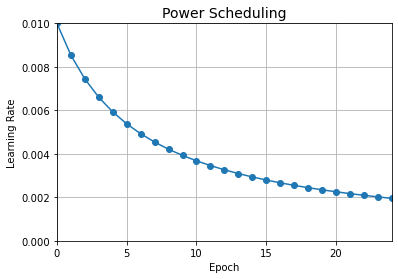

In [32]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [33]:
## Exponential Scheduling
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8295 - accuracy: 0.7602 - val_loss: 0.7660 - val_accuracy: 0.7976
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6672 - accuracy: 0.7981 - val_loss: 0.7441 - val_accuracy: 0.7976
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5934 - accuracy: 0.8173 - val_loss: 0.7156 - val_accuracy: 0.7826
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5269 - accuracy: 0.8380 - val_loss: 0.7140 - val_accuracy: 0.8080
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5063 - accuracy: 0.8409 - val_loss: 0.6247 - val_accuracy: 0.8298
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4468 - accuracy: 0.8561 - val_loss: 0.5791 - val_accuracy: 0.8246
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4211 - accuracy: 0.8633 - val_loss: 0.4660 - val_accuracy:

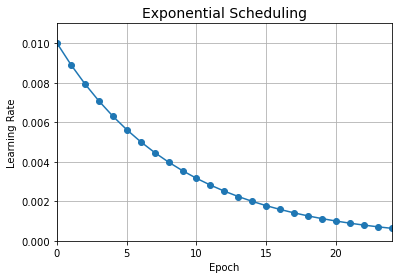

In [35]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [36]:
## Piecewise constant scheduling
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [37]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.9139 - accuracy: 0.7435 - val_loss: 0.9956 - val_accuracy: 0.6576
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9046 - accuracy: 0.7290 - val_loss: 0.9662 - val_accuracy: 0.7184
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9898 - accuracy: 0.6946 - val_loss: 0.7441 - val_accuracy: 0.7690
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9004 - accuracy: 0.7171 - val_loss: 1.0430 - val_accuracy: 0.5872
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0519 - accuracy: 0.6448 - val_loss: 0.9499 - val_accuracy: 0.7070
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6929 - accuracy: 0.7753 - val_loss: 0.6733 - val_accuracy: 0.8114
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5903 - accuracy: 0.8015 - val_loss: 0.7792 - val_accuracy:

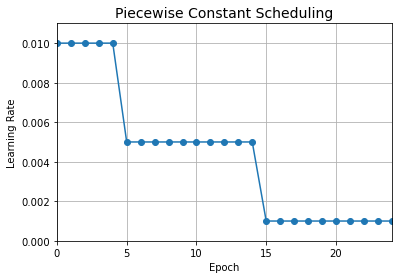

In [38]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [40]:
## Performance Scaling
tf.random.set_seed(42)
np.random.seed(42)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5900 - accuracy: 0.8068 - val_loss: 0.4719 - val_accuracy: 0.8506
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4897 - accuracy: 0.8415 - val_loss: 0.6139 - val_accuracy: 0.8268
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5159 - accuracy: 0.8403 - val_loss: 0.5231 - val_accuracy: 0.8482
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5217 - accuracy: 0.8467 - val_loss: 0.4573 - val_accuracy: 0.8538
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5321 - accuracy: 0.8478 - val_loss: 0.4612 - val_accuracy: 0.8562
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4952 - accuracy: 0.8553 - val_loss: 0.5051 - val_accuracy: 0.8456
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4987 - accuracy: 0.8570 - val_loss: 0.5012 - val_accuracy:

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## Regularization in DNN

### $l_1$ and $l_2$ Regularization
Come per altri modelli posso vincolare i pesi delle connessioni tra layer utilizzando delle penalizzazioni basate su norme $l_1$ o $l_2$. In Keras introducono tale regolarizzazione mediante il parametro **kernel_regularizer**.

In [42]:
model = keras.models.Sequential([    
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


### Dropout
Dropout e' un metodo di regolarizzazione che si e' dimostrato molto efficace. Ad ogni training step, ogni neurone ha una probabilita' $p$ di essere disattivato, cioe' viene ignorato durante lo step di training. Il parametro $p$ e' detto **dropout rate** ed e' settato tra $0.1$ e $0.5$ nelle feedforward, tra $0.2$ e $0.3$ nelle RNN e tra $0.4$ e $0.5$ nelle CNN.

![](dnn_16.png)

Dropout genera una sorta di ensemble di reti non indipendenti.

Nel testing si deve moltiplicare ogni peso di input per la **keep probability** $1-p$.

In Keras, Dropout viene implementato dal layer **Dropout**:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

### Max-Norm Regularization
Per ogni neurone, si vincolano i pesi in ingresso  tale che $||w||_2\leq r$. In questo modo non viene aggiunto un termine di regolarizzazione ma una rescaling dei pesi. Riducendo $r$ si aumenta la quantita' di regolarizzazione e riduce l'overfitting. 

In Keras la max-norm regularization viene inserita mediante il parametro **kernel_constraint**:

In [45]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4751 - accuracy: 0.8321 - val_loss: 0.3832 - val_accuracy: 0.8660
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3534 - accuracy: 0.8721 - val_loss: 0.3857 - val_accuracy: 0.8632
